In [10]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from keras.datasets import cifar10

In [11]:
# CIFAR-10 데이터셋 적재 
# x_train = [50000, 32, 32, 3]  Numpy 배열
# x_test = [10000, 32, 32, 3]   Numpy 배열

# y_train과 y_test는 각 이미지의 클래스에 해당하는 0 ~ 9 사이의 정수 레이블을 가지고 있음 
# y_train = [50000, 1]
# y_test = [10000, 1]

(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

NUM_CLASSES = 10

# 신경망은 입력이 -1 ~ 1 사이 범위에 놓여 있을 때 가장 잘 동작하기 때문에 255로 나눔 
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 이미지의 정수 레이블을 원핫인코딩 벡터로 바꿈 
# 어떤 이미지의 클래스 정수 레이블이 i라면 
# 원핫 인코딩은 i 번째 원소가 1이고 그 외에는 모두 길이가 10(클래스개수)인 벡터다.
# 따라서 y_train, y_test 는 [50000, 10], [10000, 10] 이다.
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

In [12]:
from keras.layers import Input, Flatten, Dense, Conv2D
from keras.models import Model

# 합성곱을 이용해 모델 생성 
input_layer = Input(shape = (32, 32, 3))

conv_layer_1 = Conv2D(
    filters = 10
    , kernel_size = (4,4)
    , strides = 2 # 필터가 한 번에 입력 위를 이동하는 크기 -> 크게하면 출력 텐서의 크기가 줄어든다.
    , padding = 'same'
    )(input_layer)
# Conv_1 출력 -> (? x 16 x 16 x 10)

conv_layer_2 = Conv2D(
    filters = 20
    , kernel_size= (3, 3)
    , strides = 2
    , padding = 'same'
    )(conv_layer_1)
# Conv_2 출력 -> (? x 8 x 8 x 20)
# Conv2D의 출력 -> batch_size, height, width, filters

flatten_layer = Flatten()(conv_layer_2)

output_layer = Dense(units = 10, activation = 'softmax')(flatten_layer)

model = Model(input_layer, output_layer)

In [13]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 10)        490       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 20)          1820      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                12810     
Total params: 15,120
Trainable params: 15,120
Non-trainable params: 0
_________________________________________________________________


In [14]:
# 모델 컴파일 

from keras.optimizers import Adam 

opt = Adam(lr = 0.0005)
model.compile(loss = 'categorical_crossentropy', 
              optimizer = opt, 
              metrics = ['accuracy']
              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
# 모델 훈련 
history = model.fit(x_train,         # 원본 이미지 데이터
                    y_train,         # 원-핫 인코딩된 클래스 레이블
                    batch_size = 32, 
                    epochs = 10,     # 반복 훈련 횟수
                    shuffle = True   # 훈련 스텝마다 배치를 훈련 데이터에서 중복을 허용하지 않고 랜덤으로 추출
                    )

Epoch 1/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.9621 - accuracy: 0.2985
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.7376 - accuracy: 0.4065
Epoch 3/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.7160 - accuracy: 0.4130
Epoch 4/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.6993 - accuracy: 0.4207
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.6961 - accuracy: 0.4245
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.6859 - accuracy: 0.4282
Epoch 7/10
1563/1563 [==============================] - 4s 3ms/step - loss: 1.6862 - accuracy: 0.4302
Epoch 8/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.6751 - accuracy: 0.4311
Epoch 9/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.6791 - accuracy: 0.4288
Epoch 10/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.667

In [16]:
# 모델 평가
# 본적 없는 데이터에서 성능을 구하는 것 (y_test)
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.7139 - accuracy: 0.4121


[1.7138773202896118, 0.4120999872684479]

In [17]:
# predict 메서드로 테스트 세트에 대한 예측 결과 확인

CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

preds = model.predict(x_test) # preds = [10000, 10], 샘플마다 10개의 클래스 확률을 담은 벡터가 반환
# 확률 배열을 argmax를 사용해 하나의 예측 결과로 바꾼다. 
# axis = -1 은 마지막 차원(클래스)으로 배열을 압축하라는 뜻 -> preds_single의 크기는 [10000, 1]
preds_single = CLASSES[np.argmax(preds, axis = -1)]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

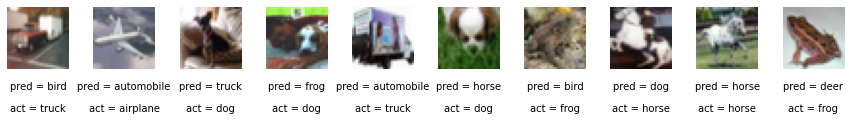

In [18]:
# 이미지의 예측값 및 실제 레이블 출력 

import matplotlib.pyplot as plt

n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize = (15, 3))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

for i, idx in enumerate(indices):
  img = x_test[idx] 
  ax = fig.add_subplot(1, n_to_show, i+1)
  ax.axis('off')
  ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize = 10, ha = 'center', transform = ax.transAxes)
  ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize = 10, ha = 'center', transform = ax.transAxes)
  ax.imshow(img)